In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
import re

In [285]:
plt.style.use('fivethirtyeight')

# Getting the data

Data will be from 1980-81 up to past season for train and validation splits. That is because prior to that season voting was done by players.

In [2]:
from collections import defaultdict

In [3]:
def work_player_profile(param, season):
    url = "https://www.basketball-reference.com" + param
    res = requests.get(url)
    soup = BeautifulSoup(res.text)
    
    data_dict = {}
    
    per_game = soup.find(attrs={'id': 'all_per_game'})
    for row in per_game.findAll("tr"):
        if 'id' in row.attrs and row.attrs['id'] == "per_game." + season:
            data_dict['fga'] = float(row.find('td', attrs={'data-stat': 'fga_per_g'}).text)
            data_dict['fg3a'] = float(row.find('td', attrs={'data-stat': 'fg3a_per_g'}).text)
            data_dict['fta'] = float(row.find('td', attrs={'data-stat': 'fta_per_g'}).text)
            break
    
    advanced_table = soup.find(attrs={'id': 'all_advanced'})
    for child in advanced_table.children:
        if "table_outer_container" in child:
            other_soup = BeautifulSoup(child)
            rows = other_soup.findAll("tr")
    for row in rows:
        if 'id' in row.attrs and row.attrs['id'] == "advanced." + season:
            data_dict.update(
                {
                    'per': float(row.find('td', attrs={'data-stat': 'per'}).text),
                    'ts_pct': float(row.find('td', attrs={'data-stat': 'ts_pct'}).text),
                    'usg_pct': float(row.find('td', attrs={'data-stat': 'usg_pct'}).text),
                    'bpm': float(row.find('td', attrs={'data-stat': 'bpm'}).text),
                    'season': str(int(season)-1) + "-" + season[-2:],
                }
            )
            return data_dict
        

In [14]:
def get_stats_of_voting(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.text)
    item = soup.find(attrs={'class': 'stats_table'})
    rows = item.findAll("tr")
    
    season = url.split(".html")[0][-4:]
    
    print(f"Current season: {season}")
    
    players_stats = defaultdict(list)
    
    for index, row in enumerate(rows):
        
        print(f"\tCurrent index: {index} of {len(rows)}")
        header_cells = row.findAll("th")
        for header_cell in header_cells:
            if 'data-stat' in header_cell.attrs and header_cell['data-stat'] == 'ranker' and 'csk' in header_cell.attrs:
                rank = int(header_cell.getText())
        td_cells = row.findAll("td")
        if not td_cells:
            continue
        for cell in td_cells:
            if 'data-stat' not in cell.attrs:
                continue
            if cell['data-stat'] == 'age':
                continue
            if cell['data-stat'] == 'team_id':
                base = "https://www.basketball-reference.com"
                try:
                    link = cell.find("a")['href']
                except Exception:
                    players_stats['win_pct'].append(0.5)  # average
                    continue
                url = base + link
                time.sleep(1)
                soup = BeautifulSoup(requests.get(url).text)
                for item in soup.findAll("p"):
                    if "Record" in item.text:
                        record = re.findall("\d+\-\d+", item.text)[0]
                        splitted = record.split("-")
                        players_stats['win_pct'].append(float(splitted[0]) / (float(splitted[1]) + float(splitted[0])))
                        break
                continue
            if cell['data-stat'] == 'player':
                time.sleep(1)
                advanced_dict = work_player_profile(cell.find("a")['href'], season)
                for key in advanced_dict:
                    players_stats[key].append(advanced_dict[key])
                players_stats[cell['data-stat']].append(cell.getText())
            else:
                text = cell.getText() or "0"
                players_stats[cell['data-stat']].append(float(text))
    return players_stats

In [ ]:
seasons = range(2016, 2019)

new_data = defaultdict(list)

for season in seasons:
    full_url = f"https://www.basketball-reference.com/awards/awards_{str(season)}.html"
    cur_season_dict = get_stats_of_voting(full_url)
    for key in cur_season_dict:
        new_data[key].extend(cur_season_dict[key])
        
data_frame = pd.DataFrame(data_mvp)
data_frame.to_csv("mvp_votings.csv")

In [20]:
for key in new_data:
    data_mvp[key].extend(new_data[key])

In [ ]:
data_frame = pd.DataFrame(data_mvp)
data_frame.to_csv("mvp_votings.csv")

### Load data

In [3]:
data_frame = pd.read_csv("mvp_votings.csv")

# Finding best features

In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
orig_features = ['fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
       'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct', 'ws',
       'ws_per_48', 'win_pct']


In [7]:
x_data = data_frame[orig_features].to_numpy()
y_data = data_frame[['award_share']].to_numpy()
y_data = y_data.reshape(y_data.shape[0], )

## Using Random forest to check most significant features

In [8]:
regressor = RandomForestRegressor(n_estimators=200)

In [9]:
regressor.fit(x_data, y_data)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
sorted_indices = np.argsort(regressor.feature_importances_)[::-1]

In [11]:
for index in sorted_indices:
    print(f"{orig_features[index]}: {regressor.feature_importances_[index]}")

ws: 0.40651032881353694
win_pct: 0.12516923391566231
per: 0.09620828488856095
bpm: 0.05180647439660696
ws_per_48: 0.037306876283414836
fga: 0.03628823279036492
usg_pct: 0.02922362860650428
ft_pct: 0.027996304407172944
ast_per_g: 0.024380031499797675
fg_pct: 0.022485588465302166
mp_per_g: 0.022081776438384656
fta: 0.02187362197773666
pts_per_g: 0.018496710202897785
trb_per_g: 0.01616551911325858
fg3_pct: 0.016158514189164693
ts_pct: 0.015414174749726362
blk_per_g: 0.011512056523768808
stl_per_g: 0.010514733414184891
fg3a: 0.010407909323953446


It kinda seems that only using Win shares we can conclude which player won the most points.

## Using feature selection

In [12]:
selector = SelectKBest(mutual_info_regression, k=5)

In [13]:
best_feat = selector.fit_transform(x_data, y_data)

In [14]:
sorted_indices = np.argsort(selector.scores_)[::-1]

In [15]:
for index in sorted_indices:
    print(f"{orig_features[index]}: {selector.scores_[index]:.4f}")

ws: 0.3037
per: 0.2628
ws_per_48: 0.2598
bpm: 0.1992
pts_per_g: 0.1482
win_pct: 0.1152
usg_pct: 0.1012
fta: 0.0967
fga: 0.0875
ts_pct: 0.0773
trb_per_g: 0.0702
mp_per_g: 0.0626
stl_per_g: 0.0467
fg3a: 0.0269
ast_per_g: 0.0251
ft_pct: 0.0245
blk_per_g: 0.0168
fg_pct: 0.0127
fg3_pct: 0.0000


Same goes here, Win shares are at the top again.

## Correlation matrix

In [16]:
data = data_frame[orig_features + ["award_share"]]

In [17]:
import seaborn as sns

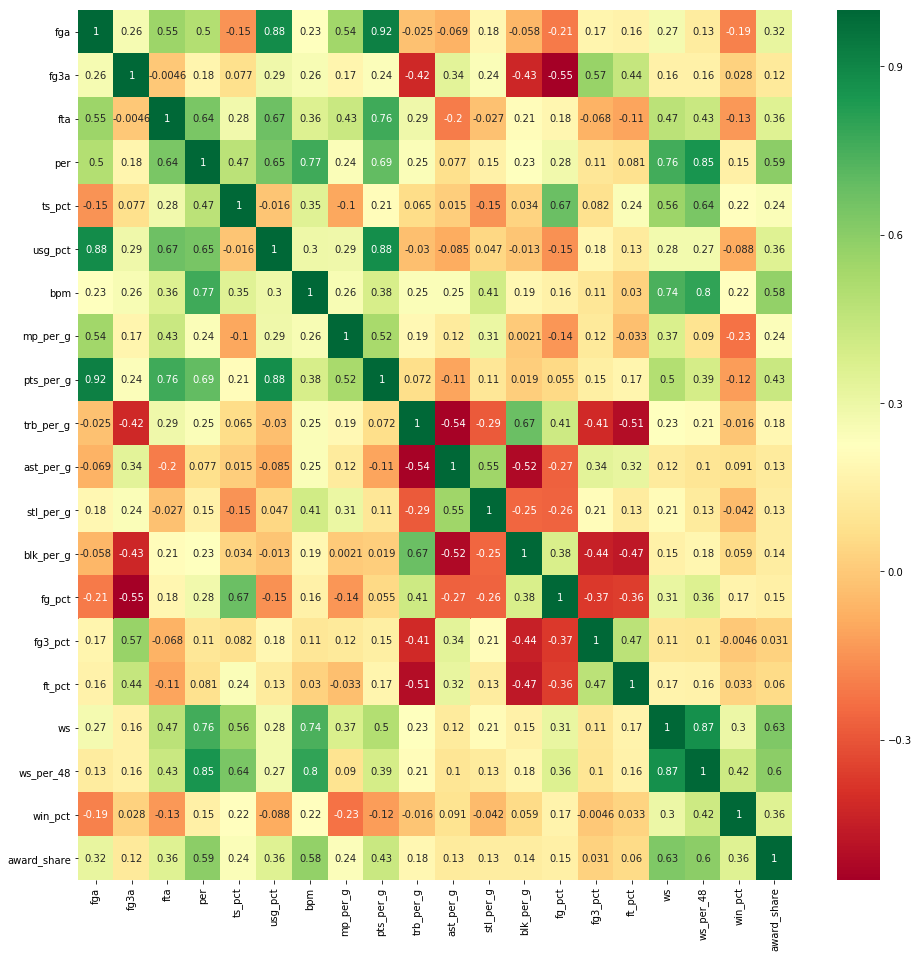

In [18]:
fig = plt.figure(figsize=(16, 16))

fig.set_facecolor('white')

sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")

BPM and PER represent similar stat. 

Points per game is directly connected with usage

I will remove now all percentages because true shooting percentage is enough. Also, WS per 48 can be removed since WS are better and that is just scaled value.

Also, the attempts will be removed since they are included in usage stat.

Since per and BPM model similiar stat, I will use BPM only

In [19]:
features = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'win_pct']

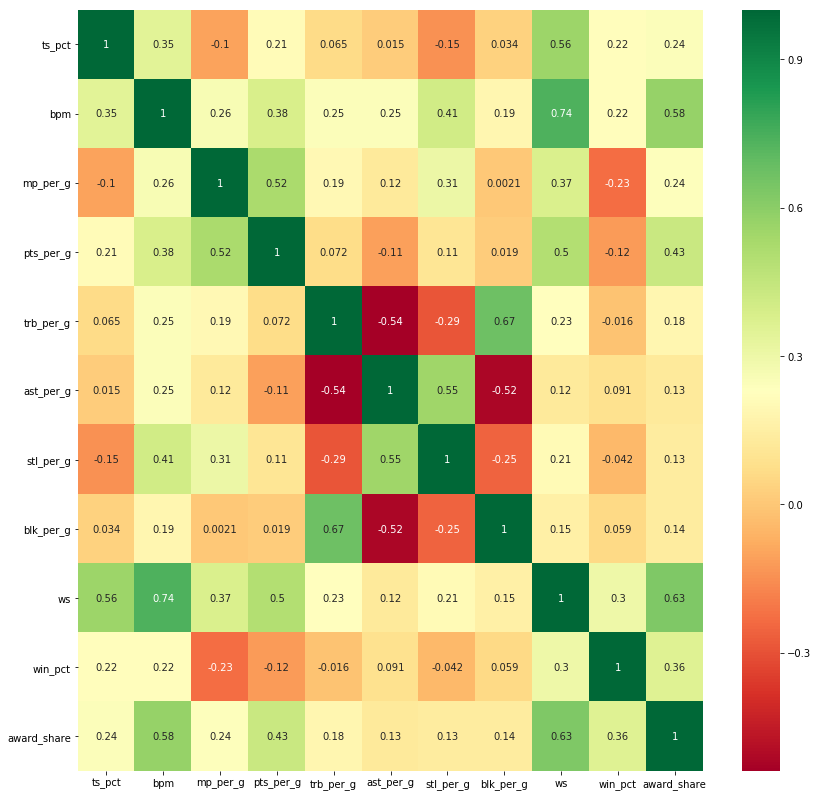

In [20]:
data = data_frame[features + ["award_share"]]
fig = plt.figure(figsize=(14, 14))

fig.set_facecolor('white')

sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")
_ = plt.yticks(rotation='horizontal')

In [21]:
data = data_frame[orig_features]

In [22]:
from sklearn.decomposition import PCA

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

In [25]:
transformed = scaler.fit_transform(data)

In [26]:
pca = PCA(n_components=1)

In [27]:
decomposed = pca.fit_transform(transformed)

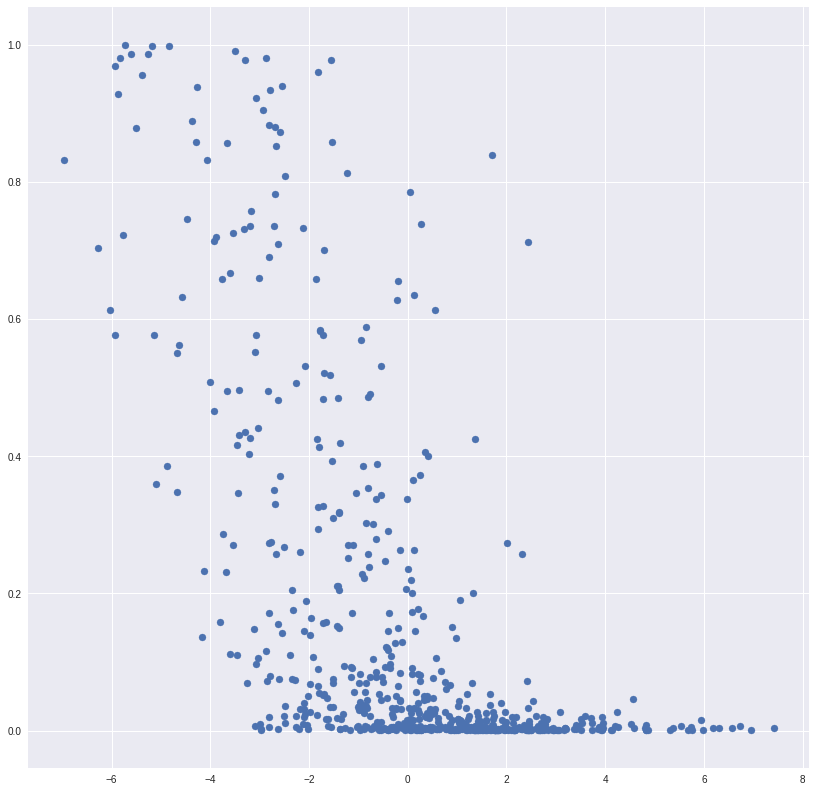

In [28]:
plt.figure(figsize=(14, 14))

plt.scatter(decomposed, data_frame.award_share)

We can see that the data doesn't really fit that well the regression task, but we gotta work with what we have.

Text(0.5, 0, 'Award share')

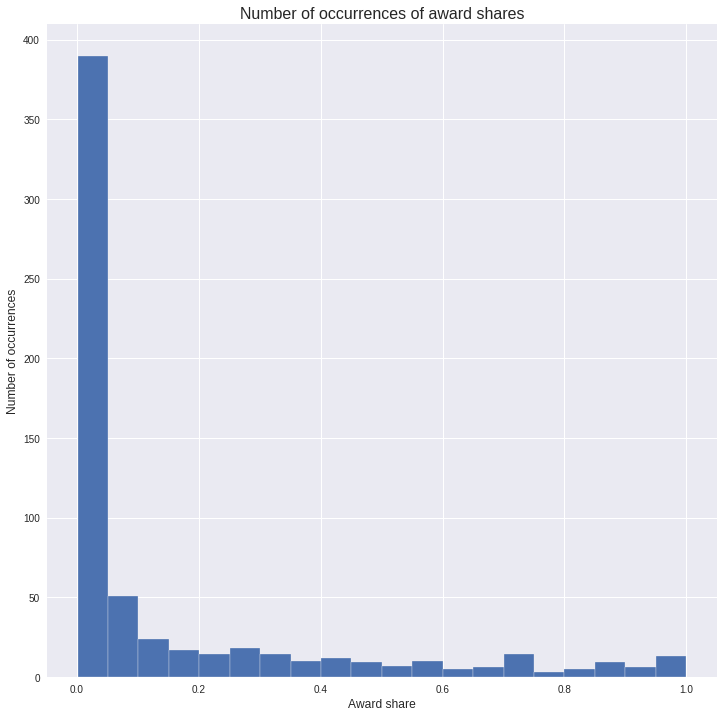

In [29]:
plt.figure(figsize=(12, 12))

plt.hist(data_frame.award_share, bins=20, edgecolor='#F5F5F5')
plt.title("Number of occurrences of award shares", size=16)
plt.ylabel("Number of occurrences", size=12)
plt.xlabel("Award share", size=12)

# Defining the pipeline

In [30]:
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [32]:
import logging

In [156]:
def pipeline(data_frame, estimators, params, filename, poly_fit = None, scaler = None):
    
    unique_seasons = data_frame.season.unique()
    train_columns = ['ts_pct', 'bpm', 'usg_pct', 'pts_per_g', 'trb_per_g', 'per', 'ws','ws_per_48', 'win_pct']
    target_columns = ['award_share']
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename, filemode='w', level=logging.INFO)
    logger = logging.getLogger()
    
    minimal_error, best_estimator = None, None
    
    for estimator in estimators:
        
        try: 
            print(f"Starting with estimator: {estimator.__name__}")
            logging.info(f"Starting with estimator: {estimator.__name__}")

            for index, cur_params in enumerate(params[estimator.__name__]):

                regressor = estimator(**cur_params)

                # To collect MSE over each split
                errors = []

                # to collect accuracies
                accuracies = []
                top_1_accs = []

                for season in unique_seasons:
                    
                    train_data = data_frame.loc[data_frame.season != season]
                    validation_data = data_frame.loc[data_frame.season == season]
                    validation_data = validation_data.sort_values(by='award_share', ascending=False)

                    # Get train data
                    train_x = train_data[train_columns].to_numpy()
                    train_y = train_data[target_columns].to_numpy()
                    train_y = train_y.reshape(train_y.shape[0], )

                    # Validate over one season only
                    val_x = validation_data[train_columns].to_numpy()
                    val_y = validation_data[target_columns].to_numpy()
                    val_y = val_y.reshape(val_y.shape[0], )

                    if poly_fit is not None:
                        # poly_fit = PolynomialFeatures(degree=2,interaction_only=False)
                        train_x = poly_fit.fit_transform(train_x)
                        val_x = poly_fit.fit_transform(val_x)

                    if scaler is not None:
                        train_x = scaler.fit_transform(train_x)
                        val_x = scaler.fit_transform(val_x)
                        
                    shuffle_x, shuffle_y = shuffle(train_x, train_y)

                    regressor.fit(shuffle_x, shuffle_y)
                    predicted_y = regressor.predict(val_x)

                    sorted_indices = np.argsort(predicted_y)[::-1]
                    correct_indices = np.arange(len(val_y))

                    accuracy = np.sum(sorted_indices[:5] == correct_indices[:5]) / len(correct_indices[:5])
                    accuracies.append(accuracy)
                    
                    top_1_accs.append(
                        np.sum(sorted_indices[:1] == correct_indices[:1]) / len(correct_indices[:1])
                    )
                    curr_error = mean_squared_error(val_y, predicted_y)
                    errors.append(curr_error)

                mean_error = np.average(errors)
                mean_accuracy = np.average(accuracies)
                mean_acc_at_1 = np.average(top_1_accs)
                logging.info(f"Params: {cur_params}, MSE over all splits is: {mean_error:.4f}, Mean acc at 5: {mean_accuracy:.4f}, Mean acc at 1: {mean_acc_at_1:.4f}")
                print(
                    f"Params: {cur_params}, MSE over all splits is: {mean_error:.4f}, Mean acc at 5: {mean_accuracy:.4f}, Mean acc at 1: {mean_acc_at_1:.4f}"
                )


                if minimal_error is None or mean_error < minimal_error:
                    minimal_error = mean_error
                    best_estimator = estimator(*cur_params)
        except Exception:
            print(f"Exception: {estimator}")
            continue
            
    return best_estimator
        

In [147]:
def define_rbf_svr():
    dicts = []
    for C in [0.1, 1, 10, 50, 100]:
        for gamma in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
            dicts.append(
                {
                    'kernel': 'rbf',
                    'C': C,
                    'gamma': gamma
                }
            )
    return dicts

def define_poly_svr():
    dicts = []
    for C in [0.1, 1, 10, 100]:
        for gamma in [0.0001, 0.001, 0.01, 0.1]:
            for degree in [1, 2, 3]:
                dicts.append(
                    {
                        'kernel': 'poly',
                        'C': C,
                        'gamma': gamma,
                        'degree': degree
                    }
                )
    return dicts

def define_linear_svr():
    dicts = []
    for C in [0.1, 1, 10, 100]:
        dicts.append(
            {
                'kernel': 'linear',
                'C': C
            }
        )
    return dicts

In [148]:
def define_gradient_boosting_regressor():
    dicts = []
    for estimator in [10, 50, 100, 200]:
        for learning_rate in [0.1, 0.01, 0.001, 0.0001, 1]:
            for subsample in [0.5, 1.0]:
                dicts.append(
                    {
                        'n_estimators': estimator,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                    }
                )
    return dicts

def define_adaboost_regressor():
    dicts = []
    BaggingRegressor
    for n_estimators in [10, 50, 100, 200]:
        for learning_rate in [0.0001, 0.001, 0.01, 0.1, 1]:
            dicts.append(
                {
                    'base_estimator': Ridge(alpha=10.0),
                    'n_estimators': n_estimators,
                }
            )
    return dicts

In [149]:
def get_elastic_net_params():
    dicts = []
    for alpha in [0.2, 0.5, 1.0, 2.0, 5.0]:
        for ratio in [0.2, 0.4, 0.5, 0.6, 0.8]:
            dicts.append(
                {
                    'alpha': alpha,
                    'l1_ratio': ratio
                }
            )
    return dicts

In [159]:
estimators = [
    LinearRegression,
    Ridge,
    RandomForestRegressor,
    #ElasticNet,
    # AdaBoostRegressor,
    GradientBoostingRegressor,
    SVR,
    # MLPRegressor,
]
params = {
    LinearRegression.__name__: [
        {
            'n_jobs': -1,
        },
        {
            'n_jobs': -1,
            'normalize': True
        },
    ],
    Ridge.__name__: [
        {
            'alpha': 1.0
        },
        {
            'alpha': 10.0
        },
        {
            'alpha': 50.0
        },
        {
            'alpha': 100.0
        },
        {
            'alpha': 200.0
        },
        {
            'alpha': 500.0
        },
    ],
    ElasticNet.__name__: [
        *get_elastic_net_params()
    ],
    RandomForestRegressor.__name__: [
        {
            'n_estimators': 10,
            'n_jobs': -1
        },
        {
            'n_estimators': 100,
            'n_jobs': -1
        },
        {
            'n_estimators': 50,
            'n_jobs': -1
        },
        {
            'n_estimators': 50,
            'n_jobs': -1,
            'min_samples_split': 3
        },
        {
            'n_estimators': 100,
            'n_jobs': -1,
            'min_samples_split': 3
        },
        {
            'n_estimators': 200,
            'n_jobs': -1,
            'min_samples_split': 3
        },
        {
            'n_estimators': 200,
            'n_jobs': -1,
        },
    ],
    SVR.__name__: [
        # *define_poly_svr(),
        # *define_linear_svr(),
        *define_rbf_svr(),
    ],
    AdaBoostRegressor.__name__: [
        *define_adaboost_regressor()
    ],
    GradientBoostingRegressor.__name__: [
        *define_gradient_boosting_regressor()
    ],
}

In [158]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="temp.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=False),
)

Starting with estimator: LAD


/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

Params: {'epsilon': 0.001, 'max_iter': 5000}, MSE over all splits is: 0.0892, Mean acc at 5: 0.0632, Mean acc at 1: 0.2632


/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [176]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_poly_2.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=True),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 0.0350, Mean acc at 5: 0.2421, Mean acc at 1: 0.6316
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 0.0276, Mean acc at 5: 0.2895, Mean acc at 1: 0.6579
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.0269, Mean acc at 5: 0.3105, Mean acc at 1: 0.6316
Params: {'alpha': 10.0}, MSE over all splits is: 0.0270, Mean acc at 5: 0.3526, Mean acc at 1: 0.6579
Params: {'alpha': 50.0}, MSE over all splits is: 0.0275, Mean acc at 5: 0.3316, Mean acc at 1: 0.6579
Params: {'alpha': 100.0}, MSE over all splits is: 0.0280, Mean acc at 5: 0.3263, Mean acc at 1: 0.6579
Params: {'alpha': 200.0}, MSE over all splits is: 0.0285, Mean acc at 5: 0.3105, Mean acc at 1: 0.6316
Params: {'alpha': 500.0}, MSE over all splits is: 0.0291, Mean acc at 5: 0.3158, Mean acc at 1: 0.6316
Starting with estimator: RandomForestRegressor
Params: {'n_estimators': 10, 'n_jobs': -1}, M

Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}, MSE over all splits is: 0.0696, Mean acc at 5: 0.0316, Mean acc at 1: 0.0789
Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}, MSE over all splits is: 0.0696, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}, MSE over all splits is: 0.0380, Mean acc at 5: 0.2684, Mean acc at 1: 0.4737
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}, MSE over all splits is: 0.0518, Mean acc at 5: 0.1789, Mean acc at 1: 0.3421
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}, MSE over all splits is: 0.0698, Mean acc at 5: 0.0895, Mean acc at 1: 0.1579
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0421, Mean acc at 1: 0.0789
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}, MSE over all splits is: 0.0443, Mean acc at 5: 0.2789

In [177]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_poly_2_all.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=False),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 0.0382, Mean acc at 5: 0.2368, Mean acc at 1: 0.6316
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 0.0335, Mean acc at 5: 0.2632, Mean acc at 1: 0.6579
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.0270, Mean acc at 5: 0.3000, Mean acc at 1: 0.6316
Params: {'alpha': 10.0}, MSE over all splits is: 0.0272, Mean acc at 5: 0.3263, Mean acc at 1: 0.6579
Params: {'alpha': 50.0}, MSE over all splits is: 0.0276, Mean acc at 5: 0.3000, Mean acc at 1: 0.6316
Params: {'alpha': 100.0}, MSE over all splits is: 0.0280, Mean acc at 5: 0.2895, Mean acc at 1: 0.6316
Params: {'alpha': 200.0}, MSE over all splits is: 0.0283, Mean acc at 5: 0.3105, Mean acc at 1: 0.6316
Params: {'alpha': 500.0}, MSE over all splits is: 0.0288, Mean acc at 5: 0.3000, Mean acc at 1: 0.6316
Starting with estimator: RandomForestRegressor
Params: {'n_estimators': 10, 'n_jobs': -1}, M

Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}, MSE over all splits is: 0.0696, Mean acc at 5: 0.0105, Mean acc at 1: 0.0263
Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}, MSE over all splits is: 0.0696, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}, MSE over all splits is: 0.0406, Mean acc at 5: 0.2526, Mean acc at 1: 0.5263
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}, MSE over all splits is: 0.0591, Mean acc at 5: 0.1316, Mean acc at 1: 0.2368
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}, MSE over all splits is: 0.0707, Mean acc at 5: 0.1158, Mean acc at 1: 0.2105
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0105, Mean acc at 1: 0.0263
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}, MSE over all splits is: 0.0521, Mean acc at 5: 0.2421

In [178]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_poly_3.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=3, interaction_only=True),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 0.0673, Mean acc at 5: 0.2368, Mean acc at 1: 0.5789
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 0.0451, Mean acc at 5: 0.2316, Mean acc at 1: 0.5526
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.0311, Mean acc at 5: 0.2684, Mean acc at 1: 0.6053
Params: {'alpha': 10.0}, MSE over all splits is: 0.0299, Mean acc at 5: 0.2737, Mean acc at 1: 0.6053
Params: {'alpha': 50.0}, MSE over all splits is: 0.0290, Mean acc at 5: 0.3000, Mean acc at 1: 0.6316
Params: {'alpha': 100.0}, MSE over all splits is: 0.0287, Mean acc at 5: 0.2947, Mean acc at 1: 0.6316
Params: {'alpha': 200.0}, MSE over all splits is: 0.0284, Mean acc at 5: 0.3053, Mean acc at 1: 0.6316
Params: {'alpha': 500.0}, MSE over all splits is: 0.0281, Mean acc at 5: 0.3211, Mean acc at 1: 0.6316
Starting with estimator: RandomForestRegressor
Params: {'n_estimators': 10, 'n_jobs': -1}, M

Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}, MSE over all splits is: 0.0696, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}, MSE over all splits is: 0.0696, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}, MSE over all splits is: 0.0710, Mean acc at 5: 0.1211, Mean acc at 1: 0.1842
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}, MSE over all splits is: 0.0711, Mean acc at 5: 0.0000, Mean acc at 1: 0.0000
Params: {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}, MSE over all splits is: 0.0710, Mean acc at 5: 0.1211

In [179]:
estimators = [
    LinearRegression,
    Ridge,
    Lasso,
    # RandomForestRegressor,
    GradientBoostingRegressor,
    #SVR,
    # MLPRegressor,
]
params = {
    LinearRegression.__name__: [
        {
            'n_jobs': -1,
        },
        {
            'n_jobs': -1,
            'normalize': True
        },
    ],
    Ridge.__name__: [
        {
            'alpha': 1.0
        },
        {
            'alpha': 10.0
        },
        {
            'alpha': 50.0
        },
        {
            'alpha': 100.0
        },
        {
            'alpha': 200.0
        },
        {
            'alpha': 500.0
        },
    ],
    Lasso.__name__: [
        {
            'alpha': 1.0,
        },
        {
            'alpha': 10.0
        },
        {
            'alpha': 100.0
        },
    ],
    RandomForestRegressor.__name__: [
        {
            'n_estimators': 10,
            'n_jobs': -1
        },
        {
            'n_estimators': 50,
            'n_jobs': -1
        },
        
    ],
    SVR.__name__: [
        *define_poly_svr(),
        *define_linear_svr(),
        #*define_rbf_svr(),
    ],
    GradientBoostingRegressor.__name__: [
        *define_gradient_boosting_regressor()
    ]
}

In [180]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_scaler.txt",
    scaler=MinMaxScaler(),
    # poly_fit=PolynomialFeatures(degree=3, interaction_only=True),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 0.0500, Mean acc at 5: 0.3316, Mean acc at 1: 0.6842
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 0.0500, Mean acc at 5: 0.3316, Mean acc at 1: 0.6842
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.0485, Mean acc at 5: 0.3421, Mean acc at 1: 0.6842
Params: {'alpha': 10.0}, MSE over all splits is: 0.0414, Mean acc at 5: 0.3474, Mean acc at 1: 0.6842
Params: {'alpha': 50.0}, MSE over all splits is: 0.0378, Mean acc at 5: 0.3579, Mean acc at 1: 0.6842
Params: {'alpha': 100.0}, MSE over all splits is: 0.0413, Mean acc at 5: 0.3316, Mean acc at 1: 0.6579
Params: {'alpha': 200.0}, MSE over all splits is: 0.0482, Mean acc at 5: 0.3263, Mean acc at 1: 0.6316
Params: {'alpha': 500.0}, MSE over all splits is: 0.0578, Mean acc at 5: 0.3211, Mean acc at 1: 0.6316
Starting with estimator: Lasso
Params: {'alpha': 1.0}, MSE over all splits is: 0.0693, Mean 

In [181]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_scaler_poly_2.txt",
    scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=True),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 1.3333, Mean acc at 5: 0.2474, Mean acc at 1: 0.5263
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 1.1544, Mean acc at 5: 0.2632, Mean acc at 1: 0.5526
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.0850, Mean acc at 5: 0.3368, Mean acc at 1: 0.6842
Params: {'alpha': 10.0}, MSE over all splits is: 0.0503, Mean acc at 5: 0.3579, Mean acc at 1: 0.6579
Params: {'alpha': 50.0}, MSE over all splits is: 0.0424, Mean acc at 5: 0.3474, Mean acc at 1: 0.6842
Params: {'alpha': 100.0}, MSE over all splits is: 0.0390, Mean acc at 5: 0.3421, Mean acc at 1: 0.6842
Params: {'alpha': 200.0}, MSE over all splits is: 0.0363, Mean acc at 5: 0.3211, Mean acc at 1: 0.6579
Params: {'alpha': 500.0}, MSE over all splits is: 0.0374, Mean acc at 5: 0.3211, Mean acc at 1: 0.6579
Starting with estimator: Lasso
Params: {'alpha': 1.0}, MSE over all splits is: 0.0693, Mean 

In [182]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_scaler_poly_2_all.txt",
    scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=False),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 1.3578, Mean acc at 5: 0.2526, Mean acc at 1: 0.4474
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 1.6867, Mean acc at 5: 0.2579, Mean acc at 1: 0.3684
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.1061, Mean acc at 5: 0.3211, Mean acc at 1: 0.6316
Params: {'alpha': 10.0}, MSE over all splits is: 0.0548, Mean acc at 5: 0.3526, Mean acc at 1: 0.6579
Params: {'alpha': 50.0}, MSE over all splits is: 0.0439, Mean acc at 5: 0.3526, Mean acc at 1: 0.6842
Params: {'alpha': 100.0}, MSE over all splits is: 0.0400, Mean acc at 5: 0.3474, Mean acc at 1: 0.6842
Params: {'alpha': 200.0}, MSE over all splits is: 0.0367, Mean acc at 5: 0.3263, Mean acc at 1: 0.6316
Params: {'alpha': 500.0}, MSE over all splits is: 0.0365, Mean acc at 5: 0.3263, Mean acc at 1: 0.6579
Starting with estimator: Lasso
Params: {'alpha': 1.0}, MSE over all splits is: 0.0693, Mean 

In [183]:
best_estimator = pipeline(
    data_frame=data_frame,
    estimators=estimators,
    params=params,
    filename="log_reg_scaler_poly_3.txt",
    scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=3, interaction_only=True),
)

Starting with estimator: LinearRegression
Params: {'n_jobs': -1}, MSE over all splits is: 72.1856, Mean acc at 5: 0.0421, Mean acc at 1: 0.0789
Params: {'n_jobs': -1, 'normalize': True}, MSE over all splits is: 72.6812, Mean acc at 5: 0.0632, Mean acc at 1: 0.1842
Starting with estimator: Ridge
Params: {'alpha': 1.0}, MSE over all splits is: 0.1379, Mean acc at 5: 0.3368, Mean acc at 1: 0.6579
Params: {'alpha': 10.0}, MSE over all splits is: 0.0787, Mean acc at 5: 0.3421, Mean acc at 1: 0.6579
Params: {'alpha': 50.0}, MSE over all splits is: 0.0584, Mean acc at 5: 0.3421, Mean acc at 1: 0.6842
Params: {'alpha': 100.0}, MSE over all splits is: 0.0526, Mean acc at 5: 0.3579, Mean acc at 1: 0.6842
Params: {'alpha': 200.0}, MSE over all splits is: 0.0471, Mean acc at 5: 0.3474, Mean acc at 1: 0.6579
Params: {'alpha': 500.0}, MSE over all splits is: 0.0398, Mean acc at 5: 0.3316, Mean acc at 1: 0.6579
Starting with estimator: Lasso
Params: {'alpha': 1.0}, MSE over all splits is: 0.0693, Mea

In [141]:
train_columns = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
        'stl_per_g', 'blk_per_g', 'ws', 'win_pct']
target_columns = ['award_share']

In [255]:
season = "2015-16"
#'n_estimators': 100, 'learning_rate': 0.001, 'subsample': 0.5}
# ''n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.5, 'loss': 'huber'
model = GradientBoostingRegressor(n_estimators=50, learning_rate= 0.1, subsample=1.0)
model = RandomForestRegressor(n_estimators=50, n_jobs=-1)
# model = Ridge(alpha=0.1)
poly_fit = PolynomialFeatures(degree=3, interaction_only=True)

In [256]:
train_data = data_frame.loc[data_frame.season != season]
validation_data = data_frame.loc[data_frame.season == season]
#validation_data = validation_data.sort_values(by='award_share')

# Get train data
train_x = train_data[train_columns].to_numpy()
#train_x = poly_fit.fit_transform(train_x)
train_y = train_data[target_columns].to_numpy()
train_y = train_y.reshape(train_y.shape[0], )

# Validate over one season only
val_x = validation_data[train_columns].to_numpy()
#val_x = poly_fit.fit_transform(val_x)
val_y = validation_data[target_columns].to_numpy()
val_y = val_y.reshape(val_y.shape[0], )

In [258]:
model.fit(train_x, train_y)
predict_y = model.predict(val_x)
predict_y

array([0.82988 , 0.33518 , 0.52746 , 0.47618 , 0.25812 , 0.18638 ,
       0.104882, 0.05074 , 0.12348 , 0.051238])

In [259]:
val_y

array([1.   , 0.484, 0.482, 0.371, 0.112, 0.082, 0.038, 0.02 , 0.007,
       0.005])

## Results Analysis

In [132]:
import os

In [133]:
results = os.listdir('logs/')
result_list = []
for name in results:
    if 'log_final_features' in name:
        added_name = name.split(".txt")[0].split("log_final_features_")[1]
        estimator = None
        with open("logs/" + name) as f:
            lines = f.readlines()
        for line in lines:
            if "{" not in line:
                estimator = line.split(" ")[-1].strip()
                continue
            params = line.split("{")[1].split("}")[0].strip().replace("'", "")
            mse = float(line.split("MSE over all splits is: ")[1].split(",")[0].strip())
            acc_top_1 = float(line.split("Mean acc at 1: ")[1].strip())
            acc_top_5 = float(line.split("Mean acc at 5: ")[1].split(",")[0].strip())
            result_list.append((added_name,estimator, params, acc_top_5, acc_top_1, mse))

In [137]:
sorted_results = sorted(result_list, key=lambda item: item[-1])

In [138]:
with open('reg_results_mse_sorted.txt', 'w') as f:
    for line in sorted_results:
        string = ""
        for item in line:
            string = string + str(item) + "|"
        string += "\n"
        f.write(string)

Based on the results of couple of simple regressors, the best one is Ridge regressor with poly level 2 and all polynoms (not only interacitons). Alpha is set to 50 or 100.

# Cls attempt

It is more natural to approach this problem as a classification problem, since we need to rank players, in other words, we need to give them a class. Minimum number of players for a season is 10, so I'll limit each season to only ten players, and I'll let the classifier decide top 10 ranks.

In [78]:
cls_data_frame = None
ranks = []
minimum = None
for season in data_frame.season.unique():
    season_data = data_frame.loc[data_frame.season == season]
    num_pos = len(season_data)
    ranks = list(range(1, num_pos+1))
    season_data = season_data.sort_values(by='award_share', ascending=False)
    is_mvp = [1 if rank == 1 else 0 for rank in ranks]
    season_data['rank'] = ranks
    season_data['is_mvp'] = is_mvp
    season_data = season_data[:10]
    if cls_data_frame is None:
        cls_data_frame = season_data
    else:
        cls_data_frame = cls_data_frame.append(season_data)

In [79]:
cls_data_frame.to_csv('cls_data_frame.csv')

## Feature selection

In [75]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [76]:
features = ['fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
       'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct', 'ws',
       'ws_per_48', 'win_pct']
x_data = cls_data_frame[features].to_numpy()
y_data = cls_data_frame[['rank']].to_numpy()
scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_data)
y_data = y_data.reshape(y_data.shape[0], )

In [77]:
selector = SelectKBest(mutual_info_classif, k=5)

In [78]:
best_feat = selector.fit_transform(x_data, y_data)

In [79]:
sorted_indices = np.argsort(selector.scores_)[::-1]

In [80]:
for index in sorted_indices:
    print(f"{features[index]}: {selector.scores_[index]:.4f}")

per: 0.2472
bpm: 0.2130
ws_per_48: 0.2024
ws: 0.1613
win_pct: 0.0878
trb_per_g: 0.0635
blk_per_g: 0.0535
stl_per_g: 0.0518
ts_pct: 0.0419
usg_pct: 0.0402
pts_per_g: 0.0392
fta: 0.0381
ast_per_g: 0.0368
ft_pct: 0.0360
fg_pct: 0.0211
fg3a: 0.0190
mp_per_g: 0.0000
fg3_pct: 0.0000
fga: 0.0000


### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf = RandomForestClassifier(n_estimators=100)

In [83]:
clf.fit(x_data, y_data)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
sorted_indices = np.argsort(clf.feature_importances_)[::-1]
for index in sorted_indices:
    print(f"{features[index]}: {clf.feature_importances_[index]}")

win_pct: 0.07045285760530273
ws_per_48: 0.0692605957927698
ws: 0.06797313417636797
bpm: 0.06376022441733051
per: 0.060702595278032165
pts_per_g: 0.05464115358658442
ft_pct: 0.052663705715118636
ts_pct: 0.0506437427328556
fga: 0.04964946440566086
fg_pct: 0.04909896844957942
mp_per_g: 0.049053654632370554
ast_per_g: 0.04893833368148348
fta: 0.04884429460438513
trb_per_g: 0.04833394179969547
usg_pct: 0.046024240524036156
blk_per_g: 0.044444415935090895
fg3_pct: 0.04439268040673557
stl_per_g: 0.041658569471196755
fg3a: 0.03946342678540384


For random forest classifier there isn't any feature which really jumps out.

In [131]:
def get_max_prob_for_rank(predictions):
    indices = []
    visited = []
    # return np.argsort(predictions[:, 0])[::-1]
    return np.argsort(predictions[:, 0])[::-1] + 1
    for i in range(len(predictions)):
        rank_i_values = predictions[:,i]
        for top_rank in np.argsort(predictions[:,i])[::-1]:
            if top_rank in visited:
                continue
            indices.append(top_rank+1)
            visited.append(top_rank)
            break
    return indices

In [133]:
def mean_reciprocal_rank(preds, ground_truths):
    total_sum = 0.0
    for i in range(len(ground_truths)):
        index = np.where(preds == ground_truths)[0]
        if len(index) == 0:
            total_sum += 0.0
            continue
        total_sum += 1. / (index[0]+1)
    return total_sum / len(ground_truths)

In [134]:
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import logging

In [135]:
def cls_pipeline(data_frame, estimators, params, filename, poly_fit = None, scaler = None):
    
    unique_seasons = data_frame.season.unique()
    """
    train_columns = [
        'fga', 'fg3a', 'fta', 'fg_pct', 'fg3_pct', 'ft_pct', 'per', 'ts_pct', 'usg_pct', 'bpm',
        'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'ws_per_48'            
    ]
    
    train_columns = [
        'fga', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm', 'pts_per_g','ws_per_48'            
    ]
    """
    train_columns = ['ts_pct', 'bpm', 'per', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'usg_pct', 'win_pct']
    target_columns = ['rank']
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename, filemode='w', level=logging.INFO)
    logger = logging.getLogger()
    
    maximal_acc, best_estimator = None, None
    
    for estimator in estimators:
        
        
            print(f"Starting with estimator: {estimator.__name__}")
            logging.info(f"Starting with estimator: {estimator.__name__}")

            for index, cur_params in enumerate(params[estimator.__name__]):

                classifier = estimator(**cur_params)

                # To collect MSE over each split
                total_accuracies = []

                # to collect accuracies
                accuracies = []
                top_1_accs = []

                for season in unique_seasons:

                    train_data = data_frame.loc[data_frame.season != season]
                    validation_data = data_frame.loc[data_frame.season == season]
                    validation_data = validation_data.sort_values(by='award_share', ascending=False)

                    # Get train data
                    train_x = train_data[train_columns].to_numpy()
                    train_y = train_data[target_columns].to_numpy()
                    train_y = train_y.reshape(train_y.shape[0], )

                    # Validate over one season only
                    val_x = validation_data[train_columns].to_numpy()
                    val_y = validation_data[target_columns].to_numpy()
                    val_y = val_y.reshape(val_y.shape[0], )

                    if poly_fit is not None:
                        # poly_fit = PolynomialFeatures(degree=2,interaction_only=False)
                        train_x = poly_fit.fit_transform(train_x)
                        val_x = poly_fit.fit_transform(val_x)

                    if scaler is not None:
                        train_x = scaler.fit_transform(train_x)
                        val_x = scaler.fit_transform(val_x)

                    shuffle_x, shuffle_y = shuffle(train_x, train_y)

                    classifier.fit(shuffle_x, shuffle_y)
                    predicted_y = classifier.predict_proba(val_x)

                    # sorted_indices = np.argsort(predicted_y)[::-1]
                    # correct_indices = np.arange(len(val_y))
                    # print(predict_y)
                    indices = get_max_prob_for_rank(predicted_y)
                    
                    accuracy = np.sum(indices[:5] == val_y[:5]) / len(val_y[:5])
                    accuracies.append(accuracy)
                    
                    top_1_accs.append(
                        np.sum(indices[:1] == val_y[:1]) / len(val_y[:1])
                    )
                    #curr_error = mean_squared_error(y_true=list(val_y[:5]) + list(val_y[-3:]),
                    #                                y_pred=list(predicted_y[:5]) + list(predicted_y[-3:])
                    total_accuracies.append(mean_reciprocal_rank(preds=indices[:5], ground_truths=val_y[:5]))

                mean_total_acc = np.average(total_accuracies)
                mean_accuracy = np.average(accuracies)
                mean_acc_at_1 = np.average(top_1_accs)
                logging.info(f"Params: {cur_params}, MRR top 5 is: {mean_total_acc:.4f}, Mean acc at 5: {mean_accuracy:.4f}, Mean acc at 1: {mean_acc_at_1:.4f}")
                print(
                    f"Params: {cur_params}, MRR top 5 is: {mean_total_acc:.4f}, Mean acc at 5: {mean_accuracy:.4f}, Mean acc at 1: {mean_acc_at_1:.4f}"
                )


                if maximal_acc is None or mean_total_acc > maximal_acc:
                    maximal_acc = mean_total_acc
                    best_estimator = estimator(*cur_params)

            
    return best_estimator

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [137]:
def get_log_reg():
    dicts = []
    for C in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
        for solver in ['newton-cg', 'lbfgs']:
            dicts.append(
                {
                    'multi_class': 'multinomial',
                    'solver': solver,
                    'C': C,
                    'n_jobs': -1,
                    'max_iter': 2000
                }
            )
    return dicts
            
def get_svc():
    dicts = []
    for C in [0.001, 0.01, 0.1, 1.0, 10, 100]:
        for gamma in [0.0001, 0.001, 0.01, 0.1, 1.0]:
            dicts.append(
                {
                    'C': C,
                    'gamma': gamma,
                    'probability': True
                }
            )
    return dicts

def get_rf_cls():
    dicts = []
    for n_estimators in [10, 100, 200]:
        for min_samples_split in [2, 3]:
            dicts.append(
                {
                    'n_estimators': n_estimators,
                    'min_samples_split': min_samples_split,
                    'n_jobs': -1
                }
            )
    return dicts

def define_gradient_boosting_cls():
    dicts = []
    for estimator in [10, 50, 100]:
        for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
            for subsample in [0.5, 1.0]:
                dicts.append(
                    {
                        'n_estimators': estimator,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                    }
                )
    return dicts

In [138]:
estimators = [
    LogisticRegression,
    RandomForestClassifier,
    GradientBoostingClassifier,
    SVC,
]
params = {
    LogisticRegression.__name__: [
        *get_log_reg()
    ],
    GradientBoostingClassifier.__name__: [
        *define_gradient_boosting_cls()
    ],
    SVC.__name__: [
        *get_svc()
    ],
    RandomForestClassifier.__name__ : [
        *get_rf_cls()
    ]

}

In [139]:
best_estimator = cls_pipeline(
    data_frame=cls_data_frame,
    estimators=estimators,
    params=params,
    filename="log_cls_mrr.txt",
    scaler=MinMaxScaler(),
    # poly_fit=PolynomialFeatures(degree=4, interaction_only=True),
)

Starting with estimator: LogisticRegression
Params: {'multi_class': 'multinomial', 'solver': 'newton-cg', 'C': 0.001, 'n_jobs': -1, 'max_iter': 2000}, MRR top 5 is: 0.6632, Mean acc at 5: 0.3053, Mean acc at 1: 0.6053
Params: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'C': 0.001, 'n_jobs': -1, 'max_iter': 2000}, MRR top 5 is: 0.6632, Mean acc at 5: 0.3053, Mean acc at 1: 0.6053
Params: {'multi_class': 'multinomial', 'solver': 'newton-cg', 'C': 0.01, 'n_jobs': -1, 'max_iter': 2000}, MRR top 5 is: 0.6632, Mean acc at 5: 0.3105, Mean acc at 1: 0.6053
Params: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'C': 0.01, 'n_jobs': -1, 'max_iter': 2000}, MRR top 5 is: 0.6632, Mean acc at 5: 0.3105, Mean acc at 1: 0.6053
Params: {'multi_class': 'multinomial', 'solver': 'newton-cg', 'C': 0.1, 'n_jobs': -1, 'max_iter': 2000}, MRR top 5 is: 0.6873, Mean acc at 5: 0.3368, Mean acc at 1: 0.6316
Params: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'C': 0.1, 'n_jobs': -1, 'max_iter': 2000

KeyboardInterrupt: 

In [ ]:
best_estimator = cls_pipeline(
    data_frame=cls_data_frame,
    estimators=estimators,
    params=params,
    filename="log_cls_poly_2.txt",
    scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=True),
)

In [ ]:
best_estimator = cls_pipeline(
    data_frame=cls_data_frame,
    estimators=estimators,
    params=params,
    filename="log_cls_poly_2_all.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=2, interaction_only=False),
)

Starting with estimator: LogisticRegression
Params: {'multi_class': 'multinomial', 'solver': 'newton-cg', 'C': 0.001, 'n_jobs': -1, 'max_iter': 2000}, accuracy over all classes is: 0.2079, Mean acc at 5: 0.2211, Mean acc at 1: 0.5263
Params: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'C': 0.001, 'n_jobs': -1, 'max_iter': 2000}, accuracy over all classes is: 0.2079, Mean acc at 5: 0.2421, Mean acc at 1: 0.5526
Params: {'multi_class': 'multinomial', 'solver': 'newton-cg', 'C': 0.01, 'n_jobs': -1, 'max_iter': 2000}, accuracy over all classes is: 0.2474, Mean acc at 5: 0.2526, Mean acc at 1: 0.5789
Params: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'C': 0.01, 'n_jobs': -1, 'max_iter': 2000}, accuracy over all classes is: 0.2395, Mean acc at 5: 0.2579, Mean acc at 1: 0.5789
Params: {'multi_class': 'multinomial', 'solver': 'newton-cg', 'C': 0.1, 'n_jobs': -1, 'max_iter': 2000}, accuracy over all classes is: 0.2105, Mean acc at 5: 0.2316, Mean acc at 1: 0.5789
Params: {'multi_cl

In [ ]:
best_estimator = cls_pipeline(
    data_frame=cls_data_frame,
    estimators=estimators,
    params=params,
    filename="log_cls_poly_3.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=3, interaction_only=True),
)

In [ ]:
best_estimator = cls_pipeline(
    data_frame=cls_data_frame,
    estimators=estimators,
    params=params,
    filename="log_cls_poly_3_all.txt",
    # scaler=MinMaxScaler(),
    poly_fit=PolynomialFeatures(degree=3, interaction_only=False),
)

### Results

In [30]:
import os

In [31]:
results = os.listdir('.')
result_list = []
for name in results:
    if 'log_cls' in name:
        added_name = name.split(".txt")[0].split("log_cls")[1]
        estimator = None
        with open(name) as f:
            lines = f.readlines()
        for line in lines:
            if "{" not in line:
                estimator = line.split(" ")[-1].strip()
                continue
            params = line.split("{")[1].split("}")[0].strip().replace("'", "")
            #mse = float(line.split("MSE over all splits is: ")[1].split(",")[0].strip())
            acc_top_1 = float(line.split("Mean acc at 1: ")[1].strip())
            acc_top_5 = float(line.split("Mean acc at 5: ")[1].split(",")[0].strip())
            result_list.append((added_name,estimator, params, acc_top_5, acc_top_1))

In [32]:
sorted_results = sorted(result_list, key=lambda item: -item[-1])

In [33]:
for item in sorted_results:
    print(item)

('', 'LogisticRegression', 'multi_class: multinomial, solver: newton-cg, C: 1.0, n_jobs: -1, max_iter: 2000', 0.3421, 0.7105)
('', 'LogisticRegression', 'multi_class: multinomial, solver: lbfgs, C: 1.0, n_jobs: -1, max_iter: 2000', 0.3421, 0.7105)
('', 'SVC', 'C: 100, gamma: 0.1, probability: True', 0.3316, 0.7105)
('_mrr', 'LogisticRegression', 'multi_class: multinomial, solver: newton-cg, C: 1.0, n_jobs: -1, max_iter: 2000', 0.3421, 0.7105)
('_mrr', 'LogisticRegression', 'multi_class: multinomial, solver: lbfgs, C: 1.0, n_jobs: -1, max_iter: 2000', 0.3421, 0.7105)
('_mrr', 'RandomForestClassifier', 'n_estimators: 100, min_samples_split: 3, n_jobs: -1', 0.3211, 0.7105)
('', 'GradientBoostingClassifier', 'n_estimators: 50, learning_rate: 0.1, subsample: 0.5', 0.3263, 0.6842)
('', 'SVC', 'C: 10, gamma: 0.1, probability: True', 0.3211, 0.6842)
('', 'SVC', 'C: 100, gamma: 0.01, probability: True', 0.3211, 0.6842)
('_mrr', 'GradientBoostingClassifier', 'n_estimators: 50, learning_rate: 0.1

In [104]:
season = '2017-18'

In [105]:
train_columns = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
        'stl_per_g', 'blk_per_g', 'ws', 'per', 'win_pct']
target_columns = ['rank']

In [106]:
train_data = cls_data_frame.loc[data_frame.season != season]
validation_data = cls_data_frame.loc[data_frame.season == season]
#validation_data = validation_data.sort_values(by='award_share', ascending=False)

# Get train data
train_x = train_data[train_columns].to_numpy()
train_y = train_data[target_columns].to_numpy()
train_y = train_y.reshape(train_y.shape[0], )

# Validate over one season only
val_x = validation_data[train_columns].to_numpy()
val_y = validation_data[target_columns].to_numpy()
val_y = val_y.reshape(val_y.shape[0], )

In [107]:
# 'multi_class': 'multinomial', 'solver': 'lbfgs', 'C': 100.0, 'n_jobs': -1, 'max_iter': 2000
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=1.0, max_iter=2000, n_jobs=-1)
#model = SVC(probability=True, C=10, gamma=0.001)
#model = RandomForestClassifier(n_estimators=100, min_samples_split=3)

In [108]:
model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
model.predict_proba(val_x)

array([[0.53549216, 0.18391131, 0.12019933, 0.07713274, 0.03742477,
        0.03764238, 0.00458416, 0.00154636, 0.00134901, 0.00071779],
       [0.37499232, 0.23795557, 0.15453131, 0.12226833, 0.03858387,
        0.0438    , 0.01046086, 0.00651576, 0.00774268, 0.00314928],
       [0.06790764, 0.13855452, 0.26355533, 0.19615421, 0.13753144,
        0.05911776, 0.09961507, 0.00721826, 0.01225656, 0.01808922],
       [0.08372429, 0.1093943 , 0.10665979, 0.15958171, 0.1968173 ,
        0.17441712, 0.04303401, 0.05280967, 0.04272324, 0.03083858],
       [0.11634017, 0.1506929 , 0.1086021 , 0.18256616, 0.03043562,
        0.10391622, 0.04209724, 0.10785371, 0.12834714, 0.02914874],
       [0.04991504, 0.11357897, 0.20421493, 0.20989684, 0.09787445,
        0.10633822, 0.09653779, 0.0278316 , 0.04783076, 0.0459814 ],
       [0.04751587, 0.0743863 , 0.11604058, 0.24447418, 0.2116348 ,
        0.09911273, 0.0685396 , 0.05128707, 0.04086193, 0.04614696],
       [0.00448738, 0.01157287, 0.0196373

In [110]:
preds = model.predict_proba(val_x)
visited = []
for i in range(len(preds)):
    rank_i_values = preds[:,i]
    for top_rank in np.argsort(preds[:,i])[::-1]:
        if top_rank in visited:
            continue
        print(f"{i+1}. is index: {top_rank+1}")
        visited.append(top_rank)
        break

1. is index: 1
2. is index: 2
3. is index: 3
4. is index: 7
5. is index: 4
6. is index: 10
7. is index: 9
8. is index: 8
9. is index: 5
10. is index: 6


# Test set

In [43]:
train_columns = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
        'stl_per_g', 'blk_per_g', 'ws', 'per', 'usg_pct', 'ws_per_48']
train_regression_columns = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'win_pct']
train_cls_columns = ['ts_pct', 'bpm', 'per', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'usg_pct', 'win_pct']
target_reg_columns = ['award_share']
target_cls_columns = ['rank']

In [44]:
test_reg_columns = [
    'TS_pct', 'BPM', 'MP_x', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'WS', 'win_pct',
]
test_cls_columns = [
        'TS_pct', 'BPM','PER', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'WS', 'PER', 'USG_pct',
]

## Merging data frames

In [84]:
per_g_df = pd.read_csv('player_per_g.csv')

In [73]:
advanced_df = pd.read_csv('advanced.csv')

In [74]:
merged = pd.merge(per_g_df, advanced_df, on=['PlayerId', 'Player'])

In [75]:
sorted_merged = merged.sort_values(by='WS', ascending=False)

In [76]:
top_players = sorted_merged[:40]

In [77]:
base_url = 'https://www.basketball-reference.com/players'
win_percentages = []
for i in range(len(top_players)):
    player_id = top_players.iloc[i].PlayerId[1:]
    full_url = f'{base_url}/{player_id[0]}/{player_id}.html'
    response = requests.get(full_url)
    soup = BeautifulSoup(response.text)
    time.sleep(0.5)
    string = f"Player: {player_id} "
    for p in soup.findAll('p'):
        if "Team" in p.text:
            full_url = 'https://www.basketball-reference.com' + str(p.find('a')['href'])
            soup = BeautifulSoup(requests.get(full_url).text)
            time.sleep(0.5)
            for item in soup.findAll("p"):
                if "Record" in item.text:
                    record = re.findall("\d+\-\d+", item.text)[0]
                    splitted = record.split("-")
                    win_pct = float(splitted[0]) / (float(splitted[1]) + float(splitted[0]))
                    win_percentages.append(win_pct)
                    string += "found"
                    break
            break
    print(f"{string}")

KeyboardInterrupt: 

In [188]:
top_players.loc[:, 'win_pct'] = win_percentages

/home/daniel/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/daniel/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Load test data frame

In [114]:
data_frame = pd.read_csv("mvp_votings.csv")

In [115]:
top_players = pd.read_csv('top_players.csv')

In [116]:
cls_data_frame = pd.read_csv('cls_data_frame.csv')

In [117]:
test_data = pd.read_csv('test_data.csv')

In [312]:
data_frame.columns

Index(['Unnamed: 0', 'fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'season', 'player', 'win_pct', 'votes_first', 'points_won',
       'points_max', 'award_share', 'g', 'mp_per_g', 'pts_per_g', 'trb_per_g',
       'ast_per_g', 'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct',
       'ws', 'ws_per_48'],
      dtype='object')

In [118]:
train_columns = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
        'stl_per_g', 'blk_per_g', 'ws', 'per', 'usg_pct', 'ws_per_48']
train_regression_columns = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'win_pct']
train_cls_columns = ['ts_pct', 'bpm', 'per', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'usg_pct', 'win_pct']
target_reg_columns = ['award_share']
target_cls_columns = ['rank']

In [119]:
test_reg_columns = [
'ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'win_pct'
]
test_cls_columns = [
        'TS_pct', 'BPM','PER', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'WS', 'PER', 'USG_pct',
]

In [90]:
filtered_columns = top_players[
    [
        'Player', 'PlayerId', 'Pos_x', 'Age_x', 'Tm_x', 'G_x','MP_x', 'FGA', 'FG_pct', '3PA', '3P_pct', 
        'FTA', 'FT_pct', 'TRB', 'AST', 'STL', 'BLK', 'PTS', 'PER', 'TS_pct', 'USG_pct', 'WS', 'WS_48',
        'BPM', 'win_pct'
    ]
]

In [80]:
filtered_columns.columns = [
    'player', 'PlayerId', 'Pos_x', 'Age_x', 'Tm_x', 'g','mp_per_g', 'fga', 'fg_pct', 'fg3a', 'fg3_pct', 
    'fta', 'ft_pct', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g',
    'pts_per_g', 'per', 'ts_pct', 'usg_pct', 'ws', 'ws_per_48',
    'bpm', 'win_pct'
]

In [81]:
filtered_columns = filtered_columns.iloc[:, [0, *list(range(5, len(filtered_columns.iloc[0])))]]

In [92]:
"""test_data = filtered_columns[
    [ 'fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'player', 'win_pct', 'g', 'mp_per_g', 'pts_per_g', 'trb_per_g',
       'ast_per_g', 'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct',
       'ws', 'ws_per_48']
]"""

"test_data = filtered_columns[\n    [ 'fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',\n       'player', 'win_pct', 'g', 'mp_per_g', 'pts_per_g', 'trb_per_g',\n       'ast_per_g', 'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct',\n       'ws', 'ws_per_48']\n]"

In [313]:
test_data.columns

Index(['Unnamed: 0', 'fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'player', 'win_pct', 'g', 'mp_per_g', 'pts_per_g', 'trb_per_g',
       'ast_per_g', 'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct',
       'ws', 'ws_per_48'],
      dtype='object')

In [91]:
# test_data.to_csv('test_data.csv')

## Predict Regression

In [120]:
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.utils import shuffle

In [169]:
def get_predictions_for_regression_model(model, poly_fit, train_data, test_data, scaler=None, should_print=True):
    train_x = train_data[train_regression_columns].to_numpy()
    train_y = train_data[target_reg_columns].to_numpy()

    train_x, train_y = shuffle(train_x, train_y)
    train_y = train_y.reshape(train_y.shape[0], )
    
    test_x = test_data[test_reg_columns].to_numpy()
    test_x = np.nan_to_num(test_x)
    
    if poly_fit is not None:
        train_x = poly_fit.fit_transform(train_x)
        test_x = poly_fit.fit_transform(test_x)
    
    if scaler is not None:
        train_x = scaler.fit_transform(train_x)
        test_x = scaler.fit_transform(test_x)
    
    model.fit(train_x, train_y)
    predict_y = model.predict(test_x)
    sorted_indices = np.argsort(predict_y)[::-1]
    predictions = predict_y[sorted_indices]
    
    formatted_preds = []
    if should_print:
        print(f"Predictions:")
    for i in range(10):
        if predictions[i] < 0:
            break
        if should_print:
            print(f"{i+1}. {top_players.iloc[sorted_indices[i]].Player}: {predictions[i]}")
        formatted_preds.append((top_players.iloc[sorted_indices[i]].Player, predictions[i]))
    return formatted_preds

In [162]:
get_predictions_for_regression_model(
    model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, subsample=1.0),
    poly_fit = PolynomialFeatures(degree=2, interaction_only=False),
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. James Harden: 0.7503165092408556
2. Giannis Antetokounmpo: 0.7128233623607908
3. Joel Embiid: 0.2981501420139886
4. Kawhi Leonard: 0.26369955851669674
5. Paul George: 0.17653668514623136
6. Stephen Curry: 0.17401853065740572
7. Nikola Jokic: 0.1725925733183824
8. Russell Westbrook: 0.1306408948130648
9. Rudy Gobert: 0.1182442690242957
10. Damian Lillard: 0.10123934904712831


[('James Harden', 0.7503165092408556),
 ('Giannis Antetokounmpo', 0.7128233623607908),
 ('Joel Embiid', 0.2981501420139886),
 ('Kawhi Leonard', 0.26369955851669674),
 ('Paul George', 0.17653668514623136),
 ('Stephen Curry', 0.17401853065740572),
 ('Nikola Jokic', 0.1725925733183824),
 ('Russell Westbrook', 0.1306408948130648),
 ('Rudy Gobert', 0.1182442690242957),
 ('Damian Lillard', 0.10123934904712831)]

In [124]:
get_predictions_for_regression_model(
    model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, subsample=1.0),
    poly_fit = PolynomialFeatures(degree=2, interaction_only=True),
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. James Harden: 0.7503165092408556
2. Giannis Antetokounmpo: 0.7128233623607908
3. Joel Embiid: 0.29815014201398854
4. Kawhi Leonard: 0.26369955851669674
5. Paul George: 0.17653668514623141
6. Stephen Curry: 0.1740185306574057
7. Nikola Jokic: 0.1725925733183824
8. Russell Westbrook: 0.13064089481306476
9. Rudy Gobert: 0.11824426902429568
10. Damian Lillard: 0.10123934904712836


In [125]:
get_predictions_for_regression_model(
    model = RandomForestRegressor(n_estimators=50),
    poly_fit = PolynomialFeatures(degree=3, interaction_only=True),
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. James Harden: 0.6488600000000002
2. Giannis Antetokounmpo: 0.63826
3. Kawhi Leonard: 0.24178
4. Stephen Curry: 0.19312000000000004
5. Russell Westbrook: 0.18977999999999992
6. Nikola Jokic: 0.17467999999999992
7. Paul George: 0.14970000000000003
8. Joel Embiid: 0.13787999999999997
9. Damian Lillard: 0.1128
10. Kevin Durant: 0.11047999999999997


In [126]:
get_predictions_for_regression_model(
    model = RandomForestRegressor(n_estimators=100),
    poly_fit = PolynomialFeatures(degree=2, interaction_only=True),
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. Giannis Antetokounmpo: 0.6310100000000001
2. James Harden: 0.60273
3. Kawhi Leonard: 0.23797000000000007
4. Paul George: 0.2205600000000001
5. Stephen Curry: 0.19235
6. Nikola Jokic: 0.18689999999999998
7. Joel Embiid: 0.1748199999999999
8. Rudy Gobert: 0.14081000000000002
9. Russell Westbrook: 0.13942999999999992
10. Kevin Durant: 0.12348999999999992


In [127]:
get_predictions_for_regression_model(
    model = Ridge(alpha=10.0),
    poly_fit = PolynomialFeatures(degree=2, interaction_only=True),
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. James Harden: 0.7892392728829574
2. Giannis Antetokounmpo: 0.6896219134702817
3. Nikola Jokic: 0.31948060540152395
4. Damian Lillard: 0.21741540752261773
5. Paul George: 0.20085552624883912
6. Kevin Durant: 0.1969068609607913
7. Kawhi Leonard: 0.17613448218194344
8. Stephen Curry: 0.17381575200219318
9. Joel Embiid: 0.061180686466423884
10. Kyrie Irving: 0.05430756068296955


In [128]:
get_predictions_for_regression_model(
    model = LinearRegression(normalize=True),
    poly_fit = PolynomialFeatures(degree=2, interaction_only=True),
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. James Harden: 0.7909472985550989
2. Giannis Antetokounmpo: 0.6264787281077004
3. Dwight Powell: 0.44021169226188306
4. DeAndre Jordan: 0.3735670002124145
5. Nikola Jokic: 0.3127727855190645
6. Damian Lillard: 0.20571356093716342
7. D.J. Augustin: 0.1777310516280819
8. Paul George: 0.17198543484372708
9. Kevin Durant: 0.17101546432015446
10. Stephen Curry: 0.14732917585002814


In [130]:
get_predictions_for_regression_model(
    model = SVR(C=100, gamma=0.001),
    poly_fit = None,
    train_data=data_frame,
    test_data=test_data
)

Predictions:
1. James Harden: 0.7563476230848476
2. Giannis Antetokounmpo: 0.6746083507874783
3. Nikola Jokic: 0.21871061822342422
4. Paul George: 0.21036571339862856
5. Rudy Gobert: 0.20936196190336712
6. Damian Lillard: 0.20200699254779234
7. Kevin Durant: 0.19205147330531072
8. Kawhi Leonard: 0.13294650085702922
9. Stephen Curry: 0.13207131804327157
10. Clint Capela: 0.032160546528826855


In [131]:
get_predictions_for_regression_model(
    model = SVR(C=100, gamma=0.01),
    poly_fit = None,
    train_data=data_frame,
    test_data=test_data,
    scaler=MinMaxScaler()
)

Predictions:
1. James Harden: 1.154675740170516
2. Giannis Antetokounmpo: 1.0386462648887385
3. Nikola Jokic: 0.4901939268491997
4. Rudy Gobert: 0.4686246990682559
5. Damian Lillard: 0.36504592734324426
6. Kevin Durant: 0.3463866404815956
7. Paul George: 0.31713392580389943
8. Joel Embiid: 0.2957015900849296
9. Russell Westbrook: 0.2782817213866746
10. Stephen Curry: 0.2077814108315561


In [24]:
get_predictions_for_regression_model(
    model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.01 ,subsample=0.5),
    poly_fit = None,
    train_data=data_frame,
    test_data=test_data,
)

Predictions:
1. Giannis Antetokounmpo: 0.2954057689671746
2. James Harden: 0.2914771242253993
3. Rudy Gobert: 0.16625874725946113
4. Nikola Jokic: 0.16533157783545852
5. Stephen Curry: 0.144578519811052
6. Damian Lillard: 0.1434476414419158
7. Paul George: 0.13872571505515233
8. Kawhi Leonard: 0.1302470085313449
9. Kevin Durant: 0.12892009493992332
10. Karl-Anthony Towns: 0.1286063133521597


## "Large scale" regression prediction

I will load data from results file and run predictions.

In [160]:
poly_dict = {
    'normal': None,
    'poly_2': PolynomialFeatures(degree=2, interaction_only=True),
    'poly_2_all': PolynomialFeatures(degree=2, interaction_only=False),
    'poly_3': PolynomialFeatures(degree=3, interaction_only=True),
}

In [164]:
estimators = {
    'SVR': SVR,
    'RandomForestRegressor': RandomForestRegressor,
    'Ridge': Ridge,
    'GradientBoostingRegressor': GradientBoostingRegressor,
    'LinearRegression': LinearRegression,
}

In [166]:
from collections import defaultdict

In [220]:
def get_results(file_name, top_k=20):

    with open(file_name) as f:
        lines = f.readlines()

    predictions_counter = defaultdict(list)
    score_counter = defaultdict(list)

    for line in lines[:top_k]:
        splitted = line.split("|")
        poly = splitted[0]
        estimator = splitted[1]
        if estimator == "Lasso":
            continue
        params = splitted[2]
        param_dict = {}
        polynomial = None
        for key in poly_dict:
            if poly in key:
                polynomial = poly_dict[key]
                break
        scaler = None
        if "scaler" in poly:
            scaler = MinMaxScaler()
        for param_value in params.split(","):
            param_value = param_value.strip()
            param_value_split = param_value.split(":")
            key = param_value_split[0].strip()
            value = param_value_split[1].strip()
            if key == 'normalize':
                value = bool(value)
            elif key == "kernel":
                value = str(value)
            elif key == "n_estimators" or key == 'n_jobs' or key == 'min_samples_split':
                value = int(value)
            else:
                value = float(value)
            param_dict[key] = value

        predictions = get_predictions_for_regression_model(
            model = estimators[estimator](**param_dict),
            poly_fit = polynomial,
            train_data=data_frame,
            test_data=test_data,
            scaler=scaler,
            should_print=False
        )

        for index, item in enumerate(predictions):
            name, score = item
            predictions_counter[name].append((index+1))
            score_counter[name].append(score)
    
    return predictions_counter, score_counter

### MSE

In [296]:
predictions_counter, score_counter = get_results("reg_results_mse_sorted.txt", top_k=50)

#### By Rank

In [297]:
avg_rank = {}
for key in predictions_counter:
    if len(predictions_counter[key]) < 10:
        continue
    avg_rank[key] = np.mean(predictions_counter[key])

In [298]:
sorted_items = sorted(avg_rank.items(), key=lambda kv: -kv[1])

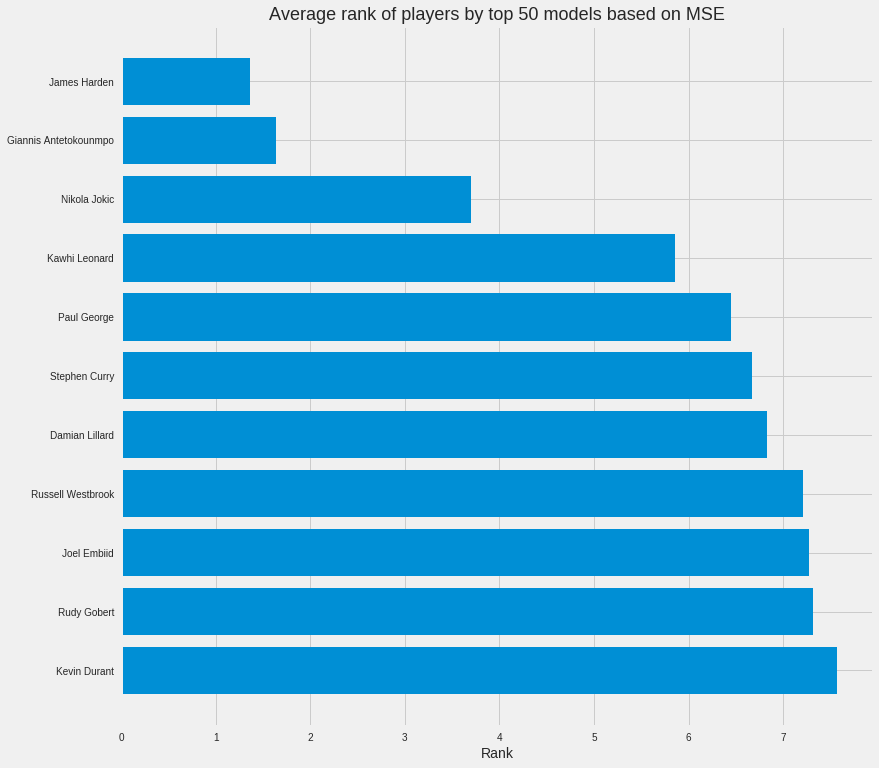

In [299]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.barh([item[0] for item in sorted_items], [item[1] for item in sorted_items])
ax.set_title("Average rank of players by top 50 models based on MSE", size=18)
_ = ax.set_xlabel("Rank", size=14)

#### By Score

In [300]:
avg_rank = {}
for key in score_counter:
    if len(score_counter[key]) < 10:
        continue
    avg_rank[key] = np.mean(score_counter[key])

In [301]:
sorted_items = sorted(avg_rank.items(), key=lambda kv: -kv[1])

In [302]:
names = [item[0].split(" ")[0][0] + ". " + item[0].split(" ")[1] for item in sorted_items]

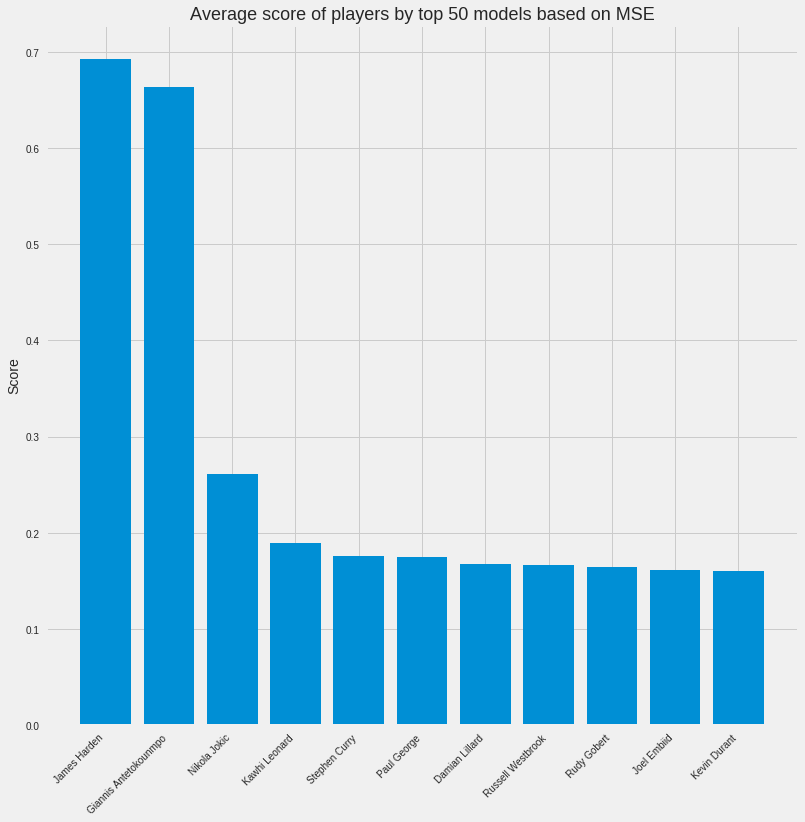

In [303]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.bar([item[0] for item in sorted_items], [item[1] for item in sorted_items])
ax.set_title("Average score of players by top 50 models based on MSE", size=18)
ax.set_ylabel("Score", size=14)
_ = ax.set_xticklabels(labels=[item[0] for item in sorted_items], rotation=45, ha='right')

### Top 1 accuracy

Check top models in predicting mvp

In [304]:
predictions_counter, score_counter = get_results("reg_results_sorted_top_1.txt", top_k=50)

In [305]:
avg_rank = {}
for key in predictions_counter:
    if len(predictions_counter[key]) < 10:
        continue
    avg_rank[key] = np.mean(predictions_counter[key])

In [306]:
sorted_items = sorted(avg_rank.items(), key=lambda kv: -kv[1])

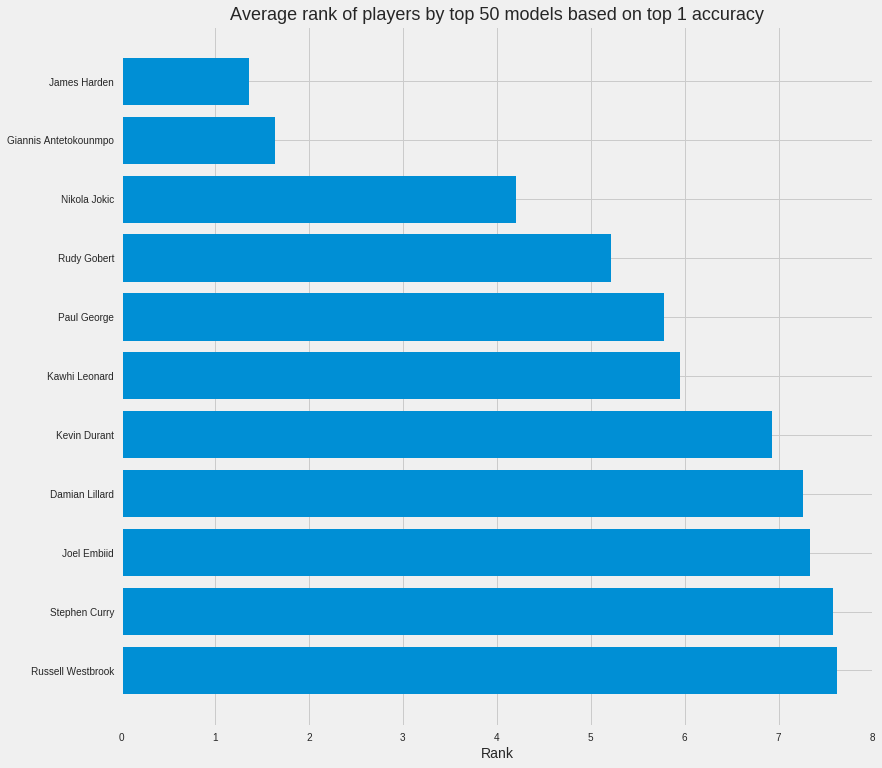

In [307]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.barh([item[0] for item in sorted_items], [item[1] for item in sorted_items])
ax.set_title("Average rank of players by top 50 models based on top 1 accuracy", size=18)
_ = ax.set_xlabel("Rank", size=14)

#### By Score

In [308]:
avg_rank = {}
for key in score_counter:
    if len(score_counter[key]) < 10:
        continue
    avg_rank[key] = np.mean(score_counter[key])

In [309]:
sorted_items = sorted(avg_rank.items(), key=lambda kv: -kv[1])

In [310]:
names = [item[0].split(" ")[0][0] + ". " + item[0].split(" ")[1] for item in sorted_items]

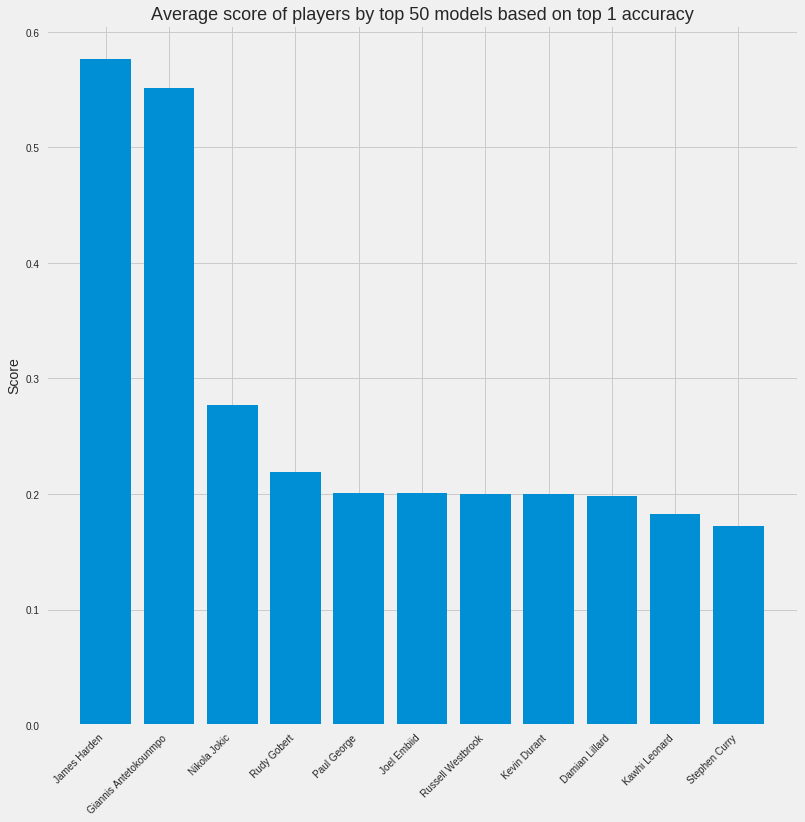

In [311]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.bar([item[0] for item in sorted_items], [item[1] for item in sorted_items])
ax.set_title("Average score of players by top 50 models based on top 1 accuracy", size=18)
ax.set_ylabel("Score", size=14)
_ = ax.set_xticklabels(labels=[item[0] for item in sorted_items], rotation=45, ha='right')

## Predict Classification

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
def get_predictions_for_cls_model(model, poly_fit, train_data, test_data, scaler=None):
    train_x = train_data[train_cls_columns].to_numpy()
    train_y = train_data[target_cls_columns].to_numpy()

    train_x, train_y = shuffle(train_x, train_y)
    train_y = train_y.reshape(train_y.shape[0], )
    
    test_x = test_data[test_cls_columns].to_numpy()
    test_x = np.nan_to_num(test_x)
    
    if poly_fit is not None:
        train_x = poly_fit.fit_transform(train_x)
        test_x = poly_fit.fit_transform(test_x)
    
    if scaler is not None:
        train_x = scaler.fit_transform(train_x)
        test_x = scaler.fit_transform(test_x)
    
    model.fit(train_x, train_y)

    preds = model.predict_proba(test_x)
    sorted_indices = np.argsort([float(item) for item in preds[:,0]])[::-1]
    for i, index in enumerate(sorted_indices[:10]):
        print(f"{i+1}. is index: {test_data.iloc[index].Player}, {preds[index,0]}")


In [27]:
get_predictions_for_cls_model(
    model = SVC(C=100, gamma=0.1, probability=True),
    poly_fit=None,
    train_data=cls_data_frame,
    test_data=top_players,
    scaler=MinMaxScaler()
)

1. is index: James Harden, 0.8872124899681998
2. is index: Giannis Antetokounmpo, 0.5915625383132933
3. is index: Joel Embiid, 0.13256664560432202
4. is index: Nikola Jokic, 0.10364580312770617
5. is index: Damian Lillard, 0.09938941629038436
6. is index: Paul George, 0.09715353483498966
7. is index: Russell Westbrook, 0.07622540795424594
8. is index: Kevin Durant, 0.06844237054322204
9. is index: Karl-Anthony Towns, 0.06418638294669467
10. is index: Kawhi Leonard, 0.03927932704101305


In [28]:
get_predictions_for_cls_model(
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=1.0),
    poly_fit=None,
    train_data=cls_data_frame,
    test_data=top_players,
    scaler=MinMaxScaler()
)

1. is index: James Harden, 0.7936514473019313
2. is index: Giannis Antetokounmpo, 0.5276188287021737
3. is index: Nikola Jokic, 0.18976004603386226
4. is index: Damian Lillard, 0.12026660153111093
5. is index: Karl-Anthony Towns, 0.09493431476682627
6. is index: Paul George, 0.0948561110744394
7. is index: Kevin Durant, 0.09068631757321668
8. is index: Joel Embiid, 0.08676239854234064
9. is index: Stephen Curry, 0.07744223868443946
10. is index: Nikola Vucevic, 0.06555454010136422


In [35]:
get_predictions_for_cls_model(
    model = RandomForestClassifier(n_estimators=100, min_samples_split=3),
    poly_fit=None,
    train_data=cls_data_frame,
    test_data=top_players,
    scaler=MinMaxScaler()
)

1. is index: James Harden, 0.7949999999999998
2. is index: Giannis Antetokounmpo, 0.5883333333333333
3. is index: Nikola Jokic, 0.231
4. is index: Joel Embiid, 0.11
5. is index: Rudy Gobert, 0.09833333333333333
6. is index: Paul George, 0.085
7. is index: Karl-Anthony Towns, 0.076
8. is index: Kevin Durant, 0.05333333333333333
9. is index: Kawhi Leonard, 0.05333333333333333
10. is index: Damian Lillard, 0.04666666666666666
